In [2]:
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
import nltk
from nltk.corpus import wordnet
import time

In [8]:
DATA_PATH = "IMDB50K/IMDB Dataset.csv"
DATASET_ENCODING = "ISO-8859-1"

In [13]:
def load_data(data_path=DATA_PATH):
    return pd.read_csv(data_path, encoding=DATASET_ENCODING)

In [14]:
data = load_data()
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
data.shape

(50000, 2)

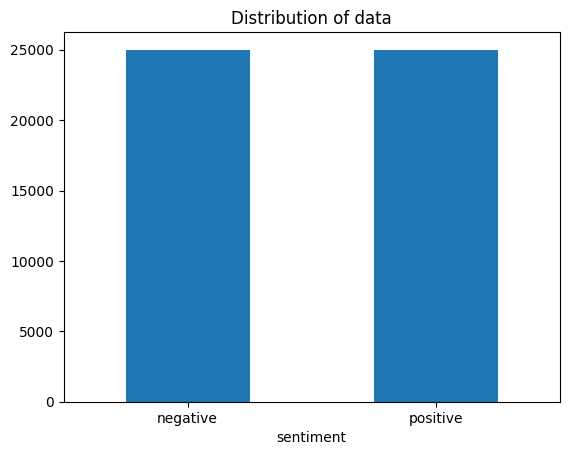

In [18]:
# Plotting the distribution for dataset.
ax = data.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['negative','positive'], rotation=0)

# Storing data in lists.
review, sentiment = list(data['review']), list(data['sentiment'])

The Data is balanced

In [22]:
print(f'data description: {data.describe()}')
print('-----------------------------------------')
print(f'Total null values: {data.isnull().sum()}')

data description:                                                    review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
-----------------------------------------
Total null values: review       0
sentiment    0
dtype: int64


There are some duplicates in the dataset

In [24]:
num_duplicates = data.duplicated().sum()
num_duplicates

418

There are 418 duplicates in the dataset

In [26]:
pd.set_option('display.max_rows', None)

In [ ]:
duplicate_rows = data[data.duplicated()]
duplicate_rows

Upon reviewing the 'duplicates,' I found that they are not true duplicates but rather multiple reviews of the same movies. Therefore, I will keep them in the dataset

In [28]:
emojis = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', ':-(': 'sad',
    ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked', ':@': 'shocked',
    ':-$': 'confused', ':\\': 'annoyed', ':#': 'mute', ':X': 'mute', ':^)': 'smile',
    ':-&': 'confused', '$_$': 'greedy', '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile',
    ':-0': 'yell', 'O.o': 'confused', '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile',
    ';)': 'wink', ';-)': 'wink', 'O:-)': 'angel', 'O*-)': 'angel', '(:-D': 'gossip',
    '=^.^=': 'cat'
}

stopwords = {
    'a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an', 'and', 'any', 'are',
    'as', 'at', 'be', 'because', 'been', 'before', 'being', 'between', 'both', 'by', 'can',
    'd', 'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
    'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him',
    'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'itself', 'just', 
    'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'not', 'o', 'of', 'on',
    'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're', 's', 
    'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such', 't', 'than', 'that', 
    "thatll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 
    'they', 'this', 'those', 'through', 'to', 'too', 'until', 'up', 've', 'very', 'was', 
    'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 
    'with', 'won', 'y', 'you', "youd", "youll", "youre", "youve", 'your', 'yours', 'yourself', 
    'yourselves'
}

In [29]:
data= data.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
df = data.copy()

In [36]:
def preprocess(reviewdata):
    processedText = []
    
    # Creating Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for review in reviewdata:
        review = review.lower()
        # Replacing all emojis.
        for emoji in emojis.keys():
            review = review.replace(emoji, "EMOJI" + emojis[emoji])              
        # Replace all non alphabets.
        review = re.sub(alphaPattern, " ", review)
        # Replace 3 or more consecutive letters by 2 letter.
        review = re.sub(sequencePattern, seqReplacePattern, review)

        reviewswords = ''
        for word in review.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                reviewswords += (word+' ')
            
        processedText.append(reviewswords)
        
    return processedText

In [37]:
t = time.time()
processedtext = preprocess(review)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 66 seconds


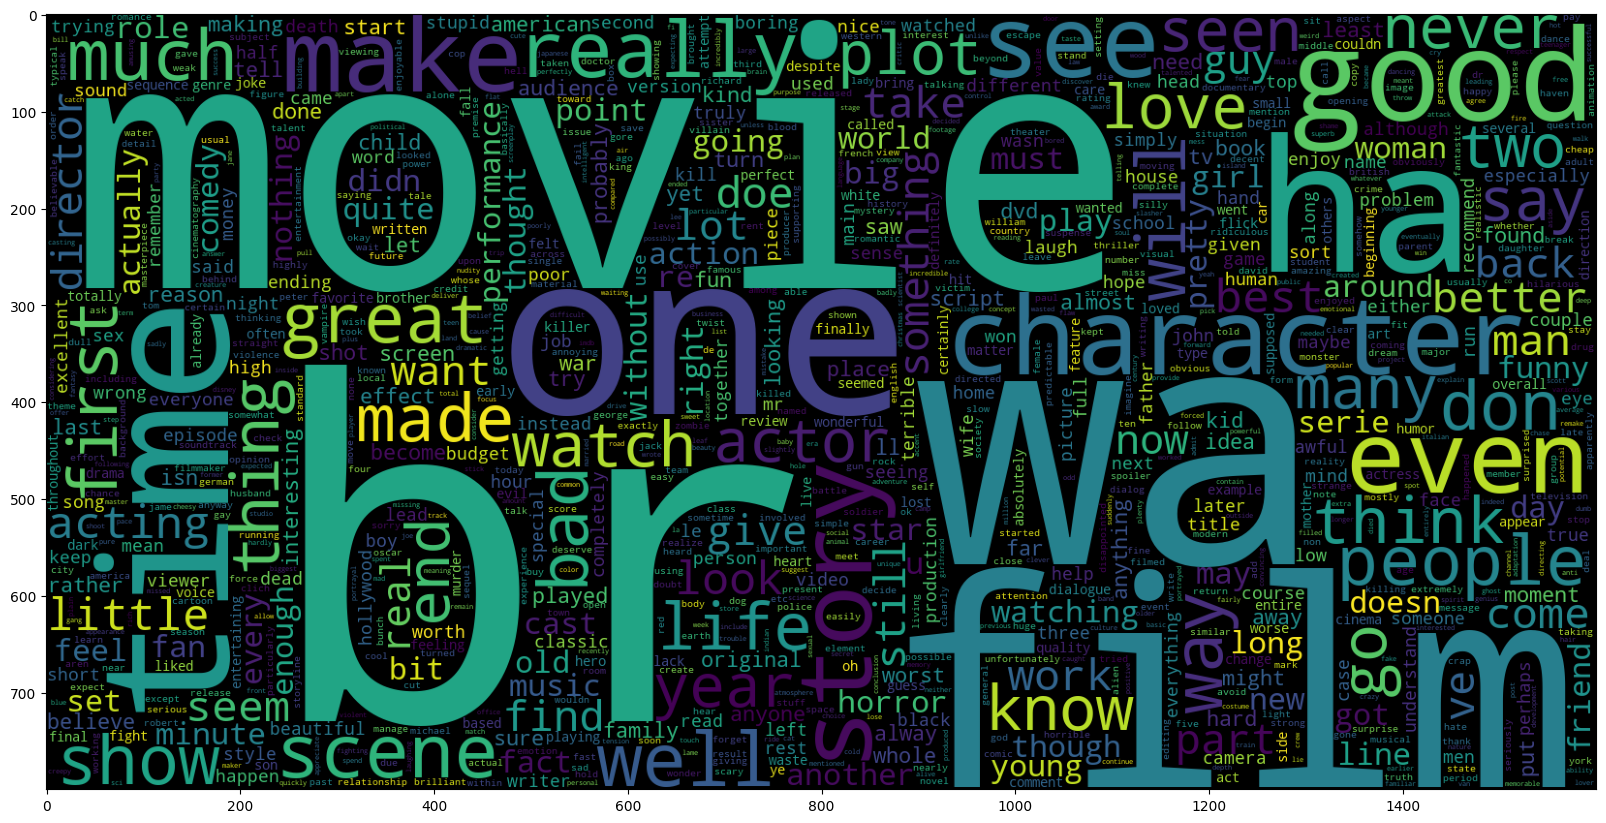

In [39]:
data_neg = processedtext[25000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)